In [22]:
import numpy as np
import tensorflow as tf

import keras

from tensorflow.keras import layers, Model
from tensorflow.keras import datasets

from tensorflow.keras.losses import MeanSquaredError, KLDivergence, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

# Data Load and Data Split

In [23]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

print("Train set shape:    ", x_train.shape)
print("Train labels shape: ", y_train.shape)
print("Test set shape:     ", x_test.shape)
print("Test labels shape:  ", y_test.shape)

Train set shape:     (50000, 32, 32, 3)
Train labels shape:  (50000, 1)
Test set shape:      (10000, 32, 32, 3)
Test labels shape:   (10000, 1)


## before normalization

In [24]:
x_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

## after normalization

In [25]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [26]:
latent_dim = 1024
image_shape = x_train[0].shape

In [27]:
mse_loss = MeanSquaredError()
kl_loss = KLDivergence()

In [28]:
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        # encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=image_shape, name="Encoder_Input_Layer"),
    
            layers.Conv2D(64, 5, activation='relu', padding='same', name="Encoder_Conv2D_1"),
            layers.BatchNormalization(name="Encoder_BatchNorm_1"),
            layers.Conv2D(64, 5, activation='relu', padding='same', name="Encoder_Conv2D_2"),
            layers.MaxPooling2D((2,2), name="Encoder_MaxPool_1"),

            layers.Conv2D(128, 5, activation='relu', padding='same', name="Encoder_Conv2D_3"),
            layers.BatchNormalization(name="Encoder_BatchNorm_2"),
            layers.Conv2D(128, 5, activation='relu', padding='same', name="Encoder_Conv2D_4"),
            layers.MaxPooling2D((2,2), name="Encoder_MaxPool_2"),

            layers.Conv2D(256, 5, activation='relu', padding='same', name="Encoder_Conv2D_5"),
            layers.BatchNormalization(name="Encoder_BatchNorm_3"),
            layers.Conv2D(256, 5, activation='relu', padding='same', name="Encoder_Conv2D_6"),
            layers.MaxPooling2D((2,2), name="Encoder_MaxPool_3"),

            layers.Flatten(name="Encoder_Flatten"),
            layers.Dense(512, activation='relu', name="Encoder_Dense_1"),
        ])
        
        # reparameterization/sampling layer 
        self.z_mean = layers.Dense(latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")
        
        # decoder
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(latent_dim,), name="Decoder_Input_Layer"),
            layers.Dense(512, activation='relu', name="Decoder_Dense_1"),
            layers.Dense(8 * 8 * 8, activation='relu', name="Decoder_Dense_2"),
            layers.Reshape((8, 8, 8), name="Decoder_Reshape"),
            layers.Conv2DTranspose(16, 5, activation='relu', padding='same', name="Decoder_Conv2DT_1"),
            layers.UpSampling2D((2,2), name="Decoder_UpSample_1"),
            layers.Conv2DTranspose(32, 5, activation='relu', padding='same', name="Decoder_Conv2DT_2"),
            layers.UpSampling2D((2,2), name="Decoder_UpSample_2"),
            layers.Conv2DTranspose(64, 5, activation='relu', padding='same', name="Decoder_Conv2DT_3"),
            layers.Conv2DTranspose(128, 5, activation='relu', padding='same', name="Decoder_Conv2DT_4"),
            layers.Conv2DTranspose(3, 5, activation='sigmoid', padding='same', name="Decoder_Conv2DT_Output")
        ])
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
     
    # Build the encoder
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var
    
    # Build the reparameterization/sampling layer 
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z
    
    # Build the decoder
    def decode(self, data):
        return self.decoder(data)
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)      
            reconstruction = self.decode(z)
            reconstruction_loss = tf.reduce_mean(
                mse_loss(data, reconstruction), 
            )
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [29]:
vae = VAE()
vae.decoder.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Decoder_Dense_1 (Dense)         │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Dense_2 (Dense)         │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Reshape (Reshape)       │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Conv2DT_1               │ (None, 8, 8, 16)       │         3,216 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_UpSample_1              │ (None, 16, 16, 16)     │             0 │
│ (UpSampling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Conv2DT_2               │ (None, 16, 16, 32)     │        12,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_UpSample_2              │ (None, 32, 32, 32)     │             0 │
│ (UpSampling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Conv2DT_3               │ (None, 32, 32, 64)     │        51,264 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Conv2DT_4               │ (None, 32, 32, 128)    │       204,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Conv2DT_Output          │ (None, 32, 32, 3)      │         9,603 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,069,299 (4.08 MB)

 Trainable params: 1,069,299 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
vae.encoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Encoder_Conv2D_1 (Conv2D)       │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_BatchNorm_1             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Conv2D_2 (Conv2D)       │ (None, 32, 32, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_MaxPool_1               │ (None, 16, 16, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Conv2D_3 (Conv2D)       │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_BatchNorm_2             │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Conv2D_4 (Conv2D)       │ (None, 16, 16, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_MaxPool_2               │ (None, 8, 8, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Conv2D_5 (Conv2D)       │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_BatchNorm_3             │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Conv2D_6 (Conv2D)       │ (None, 8, 8, 256)      │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_MaxPool_3               │ (None, 4, 4, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Flatten (Flatten)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Dense_1 (Dense)         │ (None, 512)            │     2,097,664 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,279,552 (20.14 MB)

 Trainable params: 5,278,656 (20.14 MB)

 Non-trainable params: 896 (3.50 KB)

In [31]:
vae.compile(optimizer=keras.optimizers.Adam())
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
history = vae.fit(x_train, epochs=30, batch_size=128, callbacks=[early_stopping])

# print(history.history)

Epoch 1/30
  3/391 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - kl_loss: 6.2065e-05 - loss: 0.0655 - reconstruction_loss: 0.0654  

W0000 00:00:1711715493.235085   29730 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - kl_loss: 7.7834e-04 - loss: 0.0608 - reconstruction_loss: 0.0601 - total_loss: 0.0557
Epoch 2/30
  2/391 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - kl_loss: 0.0031 - loss: 0.0457 - reconstruction_loss: 0.0425

W0000 00:00:1711715516.370456   29729 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - kl_loss: 0.0039 - loss: 0.0462 - reconstruction_loss: 0.0423 - total_loss: 0.0458
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - kl_loss: 0.0051 - loss: 0.0440 - reconstruction_loss: 0.0388 - total_loss: 0.0437
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - kl_loss: 0.0054 - loss: 0.0436 - reconstruction_loss: 0.0382 - total_loss: 0.0435
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - kl_loss: 0.0054 - loss: 0.0432 - reconstruction_loss: 0.0377 - total_loss: 0.0431
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - kl_loss: 0.0054 - loss: 0.0432 - reconstruction_loss: 0.0378 - total_loss: 0.0431
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - kl_loss: 0.0055 - loss: 0.0430 - reconstruction_loss: 0.0375 - total_loss: 0.0430
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - kl_loss: 0.0055 - loss: 0.0430 - reconstruction_loss: 0.0375 - total_loss: 0.0428
Epoch 9/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 4

In [40]:
# from datetime import datetime
# timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
# vae.save("vae_" + timestamp + ".h5")

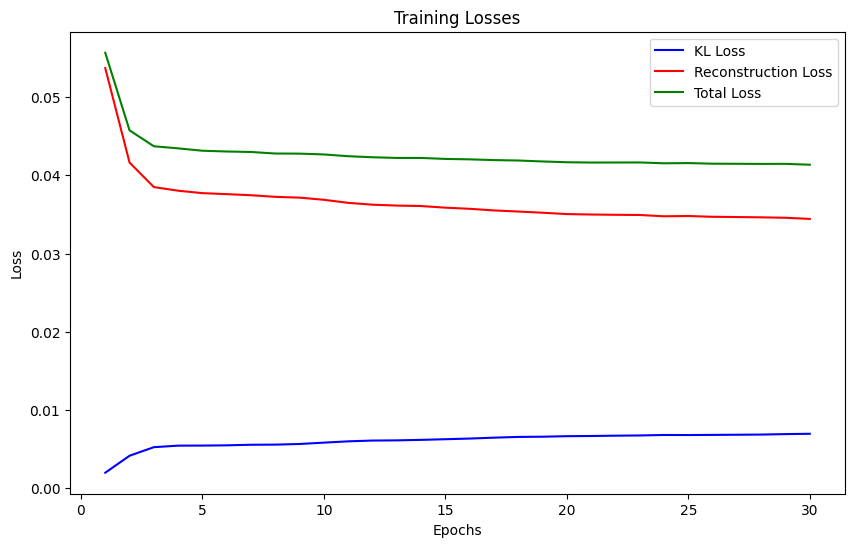

In [33]:
kl_loss = history.history['kl_loss']
reconstruction_loss = history.history['reconstruction_loss']
total_loss = history.history['total_loss']

# Plot the losses
epochs = range(1, len(kl_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, kl_loss, 'b', label='KL Loss')
plt.plot(epochs, reconstruction_loss, 'r', label='Reconstruction Loss')
plt.plot(epochs, total_loss, 'g', label='Total Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
num_images = 6

In [35]:
def generate_images_from_latent_vectors(vae, num_images_to_generate):
    # Generate random latent vectors
    random_latent_vectors = np.random.normal(size=(num_images_to_generate, latent_dim))

    # Decode the latent vectors to generate images
    generated_images = vae.decoder.predict(random_latent_vectors)

    return generated_images

# Generate images from random latent vectors
generated_images = generate_images_from_latent_vectors(vae, num_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


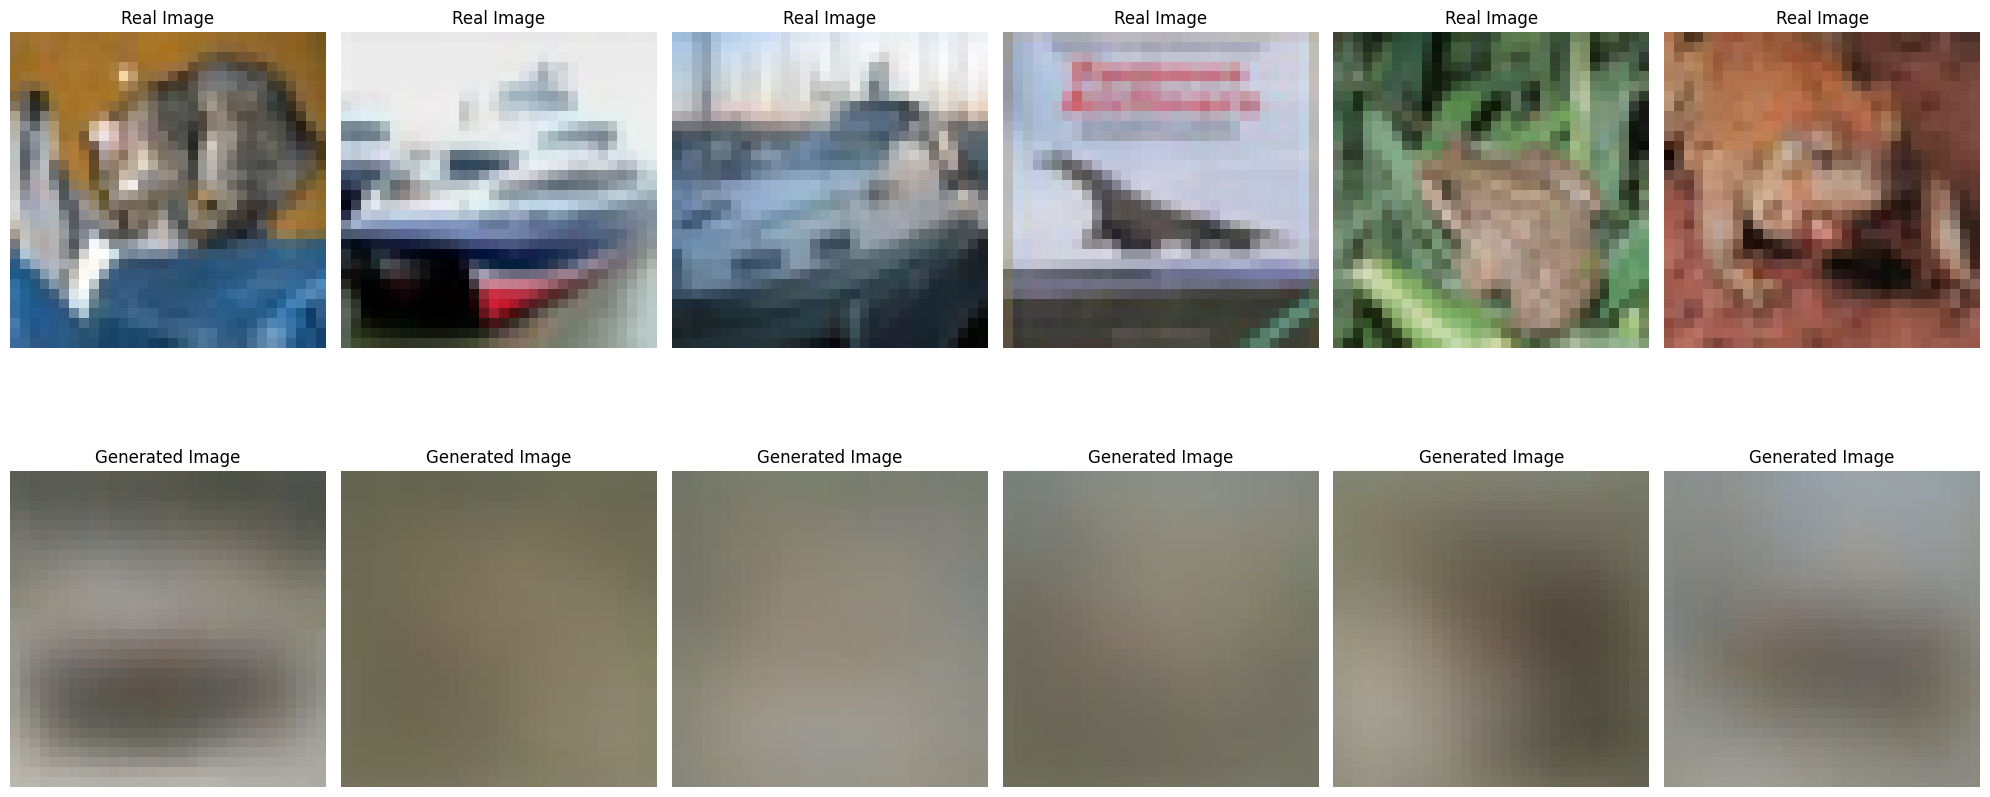

In [36]:
def plot_real_and_generated_images(real_images, generated_images, num_images_to_generate):
    plt.figure(figsize=(20, 10))

    # Plot real images
    for i in range(num_images_to_generate):
        plt.subplot(2, num_images_to_generate, i + 1)
        plt.imshow(real_images[i])
        plt.title('Real Image')
        plt.axis('off')

    # Plot generated images
    for i in range(num_images_to_generate):
        plt.subplot(2, num_images_to_generate, num_images_to_generate + i + 1)
        plt.imshow(generated_images[i])
        plt.title('Generated Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Plot real and generated images side by side vertically
plot_real_and_generated_images(x_test[:num_images], generated_images, num_images)


In [37]:
from tqdm import tqdm

def generate_latent_space(vae, n=30, scale=3):
    img_height = 32
    
    # Generate random latent vectors
    random_latent_vectors = np.random.normal(size=(n * n, latent_dim))

    generated_images = np.zeros((n * img_height, n * img_height, 3))

    for i, zi in enumerate(tqdm(np.linspace(-scale, scale, n), desc='Progress')):
        for j, zj in enumerate(np.linspace(-scale, scale, n)):
            z_sample = random_latent_vectors[i * n + j]
            # Suppress stdout temporarily
            with suppress_stdout():
                x_decoded = vae.decoder.predict(np.array([z_sample]))
            digit = x_decoded[0].reshape(img_height, img_height, 3)
            generated_images[
                i * img_height : (i + 1) * img_height,
                j * img_height : (j + 1) * img_height,
                :,
            ] = digit

    return generated_images

# Suppress stdout context manager
from contextlib import contextmanager
import os, sys

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

latent_space = generate_latent_space(vae)


Progress: 100%|██████████| 30/30 [00:55<00:00,  1.84s/it]


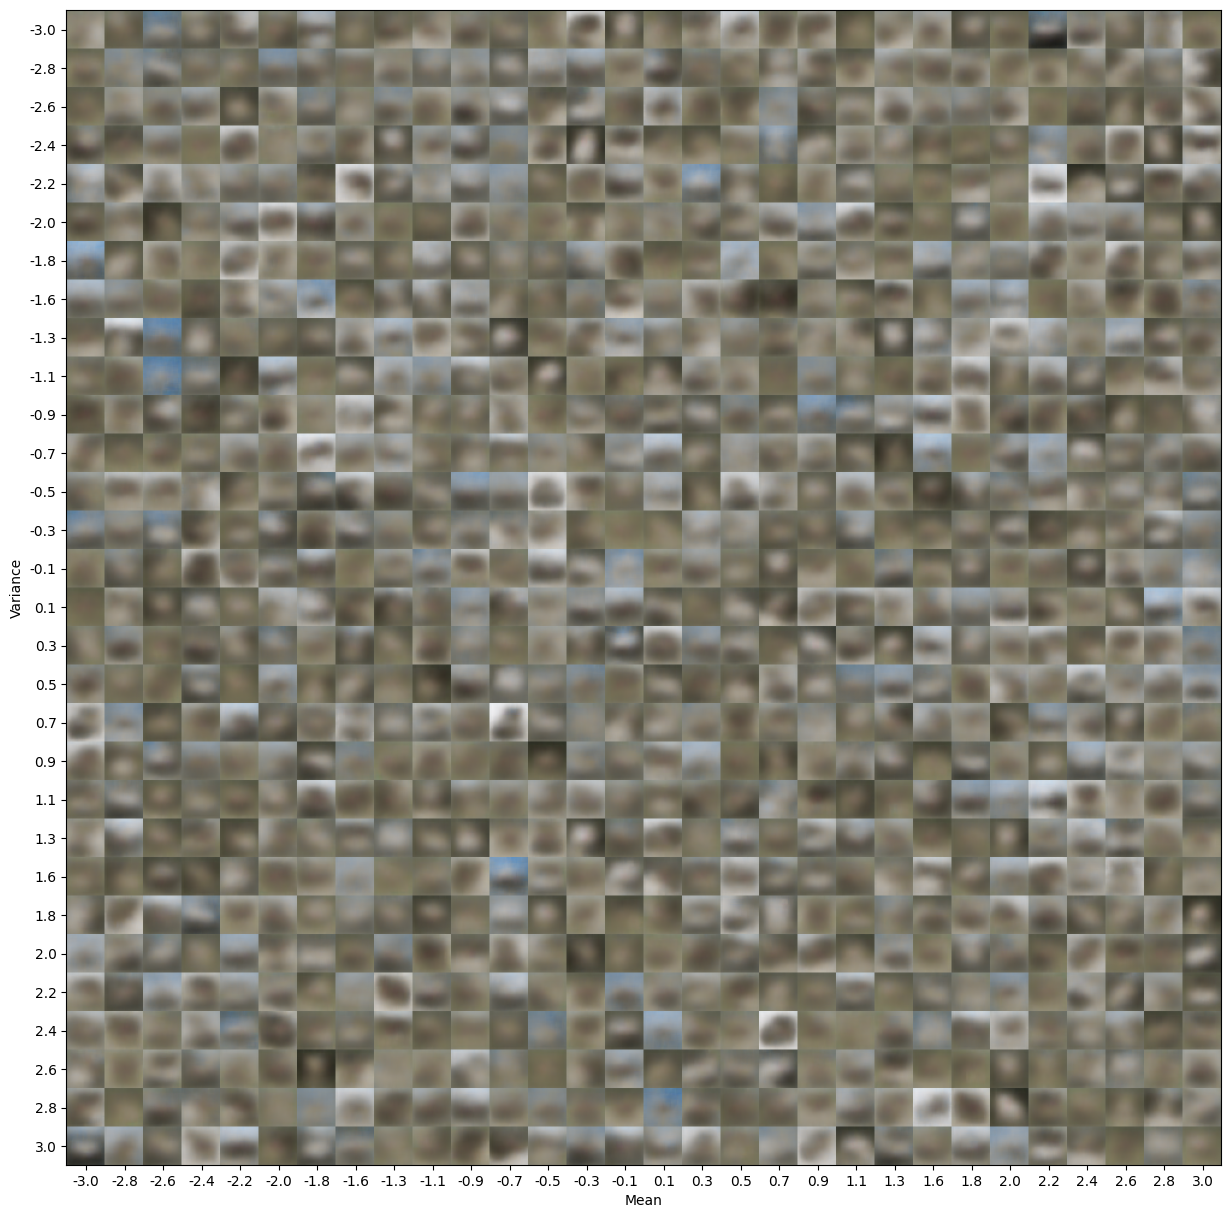

In [38]:
def plot_latent_space(generated_images, n=30, scale=3, figsize=15):
    img_height = generated_images.shape[0] // n
    
    plt.figure(figsize=(figsize, figsize))
    start_range = img_height // 2
    end_range = n * img_height + start_range
    pixel_range = np.arange(start_range, end_range, img_height)
    sample_range_x = np.round(np.linspace(-scale, scale, n), 1)
    sample_range_y = np.round(np.linspace(-scale, scale, n), 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("Mean")
    plt.ylabel("Variance")
    plt.imshow(generated_images)
    plt.show()
    
plot_latent_space(latent_space)